In [ ]:
# main modules needed
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import scale
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn import metrics
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from scipy.stats import norm 
from scipy.stats import sem
from scipy.stats import shapiro
import math



 
# keras items 
import keras
from keras import regularizers
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Dropout
from keras.layers import Flatten, Conv1D, MaxPooling1D, LSTM #CNNs
from keras.activations import relu, elu, linear, softmax
from keras.callbacks import EarlyStopping, Callback
from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.optimizers import Adam, Nadam, SGD
from keras.losses import mean_squared_error, categorical_crossentropy, logcosh
from keras.utils.np_utils import to_categorical
from keras.regularizers import l2
#from kerastuner.tuners import RandomSearch

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving X2.csv to X2 (2).csv
Saving Y2.csv to Y2 (2).csv


In [ ]:
X = pd.read_csv('X2.csv', header = None)
Y = pd.read_csv('Y2.csv', header = None)

print(X.shape)
print(X.head(5))

print(Y.shape)
print(Y.head(5))

X=(X-X.min())/(X.max()-X.min())
Y=(Y-Y.min())/(Y.max()-Y.min())

print(X.head(5))
print(Y.head(5))

(284, 1148)
   0     1     2     3     4     5     6     7     8     9     ...  1138  \
0     1     1     1    -1    -1     1     1     1    -1    -1  ...    -1   
1     1    -1     1     1     1     0     1    -1     1    -1  ...     1   
2     1    -1     1     1    -1    -1     1    -1     1    -1  ...    -1   
3     0     1     1    -1    -1    -1     1    -1    -1    -1  ...    -1   
4     1     1     1     0    -1     1     1    -1     1     1  ...    -1   

   1139  1140  1141  1142  1143  1144  1145  1146  1147  
0    -1     1    -1    -1     1    -1    -1     1     0  
1    -1     1    -1     1     1    -1     0     0    -1  
2    -1     1    -1     0     1    -1    -1     1     0  
3    -1     1    -1     1     1    -1    -1     1     0  
4    -1     1    -1    -1     1    -1    -1     1     0  

[5 rows x 1148 columns]
(284, 6)
          0          1          2         3          4          5
0  1.108000  12.623310  13.767326  1.545574  12.095075  11.571367
1  0.299160  11.1

In [ ]:
itrait=5 # first trait analyzed
X_train, X_test, y_train, y_test = train_test_split(X, Y[itrait], test_size=0.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(227, 1148) (227,)
(57, 1148) (57,)


       min max mean sd
Train: 0.0 0.8388157894683913 0.40723431566752133 0.1058507805784175
Test: 0.27500000033521 1.0 0.4224210015841556 0.11288187226894611


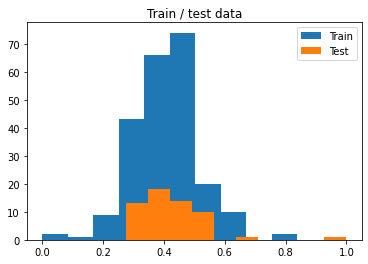

In [ ]:
# print basic statistics: max, min, mean, sd
print('       min max mean sd')
print('Train:', y_train.min(), y_train.max(), y_train.mean(), np.sqrt(y_train.var()))
print('Test:', y_test.min(), y_test.max(), y_test.mean(), np.sqrt(y_test.var()))

# do basic histograms
plt.title('Train / test data')
plt.hist(y_train, label='Train')
plt.hist(y_test, label='Test')
plt.legend(loc='best')
plt.show()

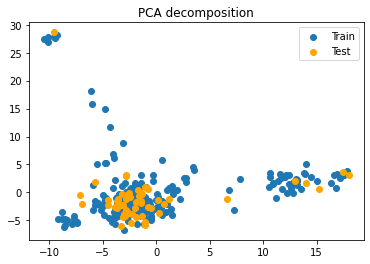

In [ ]:
# PCA
X = np.concatenate((X_train, X_test))
X = StandardScaler().fit_transform(X)
pca = PCA(n_components=2)
#X = pd.DataFrame(X).fillna(X.mean())
p = pca.fit(X).fit_transform(X)
Ntrain=X_train.shape[0]
plt.title('PCA decomposition')
plt.scatter(p[0:Ntrain,0], p[0:Ntrain,1], label='Train')
plt.scatter(p[Ntrain:,0], p[Ntrain:,1], label='Test', color='orange')
plt.legend(loc='best')
plt.show()

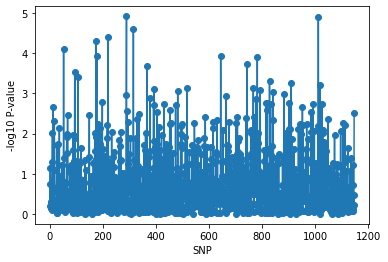

In [ ]:
pvals = []
for i in range(X_train.shape[1]):
    b, intercept, r_value, p_value, std_err = stats.linregress(X_train[X_train.columns[i]], y_train)
    pvals.append(-np.log10(p_value))
pvals = np.array(pvals)

# plot GWAS
plt.ylabel('-log10 P-value')
plt.xlabel('SNP')
plt.plot(pvals, marker='o')
plt.show()

# select N_best most associated SNPs
#N_best = X_train.shape[1] #all SNPs
N_best = 100
snp_list = pvals.argsort()[-N_best:]

# or select by min_P_value
min_P_value = 2 # P = 0.01
snp_list = np.nonzero(pvals>min_P_value)

# finally slice X
X_train = X_train[X_train.columns[snp_list]] 
X_test = X_test[X_test.columns[snp_list]]

In [ ]:
mlp_regressor = MLPRegressor(random_state=1, max_iter=500)
mlp_regressor.fit(X_train,y_train)
y_predict_mlp = mlp_regressor.predict((X_test))

mse_mlp = metrics.mean_squared_error(y_test,y_predict_mlp)

print("mse:", mse_mlp)

cv_mse_mlp= cross_val_score(mlp_regressor, X, Y[itrait], cv=10, scoring='neg_mean_squared_error')
print('\nAll MSE in prediction =',cv_mse_mlp)
avg_cv_mse_mlp = abs((sum(cv_mse_mlp))/10)
print('\nCross Validated MSE in prediction =',avg_cv_mse_mlp)
sem_mlp = sem(cv_mse_mlp)
print('\nStandard Error of MSE in prediction =',sem_mlp)


mse: 0.02829466609060464

All MSE in prediction = [-0.45650318 -0.5471403  -0.82761848 -0.68842909 -0.44237989 -0.71989846
 -0.83200407 -0.63599908 -0.98456986 -0.82474619]

Cross Validated MSE in prediction = 0.6959288604442919

Standard Error of MSE in prediction = 0.05614844312525726



MSE in prediction = 0.042462499214373325

All MSE in prediction = [-0.06575299 -0.06440999 -0.05536206 -0.0505298  -0.0622939  -0.07642986
 -0.05822843 -0.05472309 -0.03910334 -0.03872661]

Cross Validated MSE in prediction = 0.056556008100323005

Standard Error of MSE in prediction = 0.003712655677921841

Corr obs vs pred = 0.15772377532559392


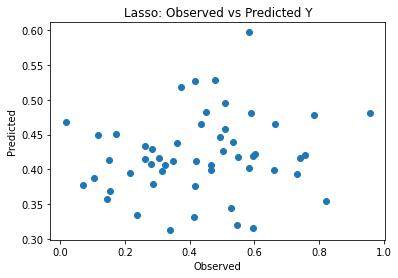

In [ ]:
# Standard penalized methods (lasso using scikit-learn)

# alpha is the regularization parameter

lasso = linear_model.Lasso(alpha=0.01, tol=0.1)
lasso.fit(X_train, y_train)
y_hat = lasso.predict(X_test)

# mean squared error
mse = metrics.mean_squared_error(y_test, y_hat)
print('\nMSE in prediction =',mse)

cv_mse_lasso = cross_val_score(lasso, X, Y[itrait], cv=10, scoring='neg_mean_squared_error')
print('\nAll MSE in prediction =',cv_mse_lasso)
avg_cv_mse_lasso = abs((sum(cv_mse_lasso))/10)
print('\nCross Validated MSE in prediction =',avg_cv_mse_lasso)
sem_lasso = sem(cv_mse_lasso)
print('\nStandard Error of MSE in prediction =',sem_lasso)

# correlation btw predicted and observed
corr = np.corrcoef(y_test,y_hat)[0,1]
print('\nCorr obs vs pred =',corr)

# plot observed vs. predicted targets
plt.title('Lasso: Observed vs Predicted Y')
plt.ylabel('Predicted')
plt.xlabel('Observed')
plt.scatter(y_test, y_hat, marker='o')
plt.show()


In [ ]:
#Random Forest

RFReg = RandomForestRegressor(n_estimators = 50, random_state = 0)
RFReg.fit(X_train, y_train)
y_predict_rfr = RFReg.predict((X_test))
mse_rand = metrics.mean_squared_error(y_test, y_predict_rfr)
print('MSE = ', mse_rand)

cv_mse_rf= cross_val_score(RFReg, X, Y[itrait], cv=10, scoring='neg_mean_squared_error')
print('\nAll MSE in prediction =',cv_mse_rf)
avg_cv_mse_rf = abs((sum(cv_mse_rf))/10)
print('\nCross Validated MSE in prediction =',avg_cv_mse_rf)
sem_rf = sem(cv_mse_rf)
print('\nStandard Error of MSE in prediction =',sem_rf)

MSE =  0.045752714342509215

All MSE in prediction = [-0.04890459 -0.06057957 -0.04007948 -0.0394355  -0.04413946 -0.07160624
 -0.05870304 -0.04820556 -0.0318474  -0.04147696]

Cross Validated MSE in prediction = 0.04849777991000048

Standard Error of MSE in prediction = 0.0037754817559876664


In [ ]:
#SVM

svm_regressor=SVR(kernel='rbf')
svm_regressor.fit(X_train,y_train)

y_predict_svm = svm_regressor.predict((X_test))
mse_svm = metrics.mean_squared_error(y_test, y_predict_svm)
print("mse:", mse_svm)
cv_mse_svm= cross_val_score(svm_regressor, X, Y[itrait], cv=10, scoring='neg_mean_squared_error')
print('\nAll MSE in prediction =',cv_mse_svm)
avg_cv_mse_svm = abs((sum(cv_mse_svm))/10)
print('\nCross Validated MSE in prediction =',avg_cv_mse_svm)
sem_svm = sem(cv_mse_svm)
print('\nStandard Error of MSE in prediction =',sem_svm)

mse: 0.04595160216019861

All MSE in prediction = [-0.05146318 -0.05900469 -0.04369017 -0.03751744 -0.04675606 -0.07292372
 -0.05348677 -0.04475378 -0.03499692 -0.04186757]

Cross Validated MSE in prediction = 0.04864603152021256

Standard Error of MSE in prediction = 0.0035393827697908792


In [ ]:
mlp_regressor=MLPRegressor(hidden_layer_sizes=(143,143,143), activation = 'relu', alpha=1.28, solver='lbfgs', learning_rate='adaptive',learning_rate_init=0.001, random_state=1, max_iter=500)
mlp_regressor.fit(X_train,y_train)

y_predict_mlp = mlp_regressor.predict((X_test))
mse_mlp = metrics.mean_squared_error(y_test,y_predict_mlp)

print("mse:", mse_mlp)

cv_mse_mlp= cross_val_score(mlp_regressor, X, Y[itrait], cv=10, scoring='neg_mean_squared_error')
print('\nAll MSE in prediction =',cv_mse_mlp)
avg_cv_mse_mlp = abs((sum(cv_mse_mlp))/10)
print('\nCross Validated MSE in prediction =',avg_cv_mse_mlp)
sem_mlp = sem(cv_mse_mlp)
print('\nStandard Error of MSE in prediction =',sem_mlp)


mse: 0.0113346164555301

All MSE in prediction = [-0.01400687 -0.01156613 -0.01306888 -0.01317561 -0.01020522 -0.00948493
 -0.03267541 -0.01302434 -0.01413819 -0.02403231]

Cross Validated MSE in prediction = 0.01553778964175257

Standard Error of MSE in prediction = 0.0022827808307151146
